In [8]:
import pandas as pd
%load_ext autoreload
%autoreload 2

from trasim_simplified.core.kinematics.cfm import get_cf_func
from trasim_simplified.core.constant import CFM

dt = 0.1
cf_name = CFM.IDM
cf_func = get_cf_func(cf_name)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹
traj_s_full_ori: dict[str, dict] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\ori_dec_acc_traj_s.pkl")
traj_s_cut_pos = {pair_id: len(df_pair) for pair_id, df_pair in traj_s_full_ori["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_ori["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_ori["dec"].items()}
obs_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
obs_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
print(len(id_s))

644


In [10]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_run

# 跟驰模型参数标定
results = clb_run(cf_func=cf_func, cf_name=cf_name,
                  obs_x_s=obs_x_s, obs_v_s=obs_v_s, obs_lx_s=obs_lx_s, obs_lv_s=obs_lv_s, leaderL_s=leaderL_s,
                  dt=0.1, seed=2024, drawing=0, n_jobs=-1)    

In [11]:
from trasim_simplified.util.calibrate.clb_cf_model import aggregate_result

avg_obj, avg_param, std_obj, std_param = aggregate_result(results)
print(f"avg_obj: {avg_obj}\navg_param: {avg_param}\nstd_obj: {std_obj}\nstd_param: {std_param}")

avg_obj: 30.134715978172395
avg_param: [ 3.60816745  0.         28.30238946  1.11105858  2.35838399  4.40908137
  5.12111801]
std_obj: 21.666300994674828
std_param: [ 2.04337655  0.         14.30806653  0.61928338  2.05332274  3.95999549
  3.59056579]


In [12]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_param_to_df

param_df = clb_param_to_df(id_s, results, cf_name)
param_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_param_df.pkl")
param_df

,s0,s1,v0,T,omega,d,delta,Pair_ID,ObjV
0,2.721968,-0.0,40.223259,1.935539,1.207851,7.672031,3.0,0,63.559033
1,2.469139,0.0,22.209832,1.048622,9.995506,5.327265,3.0,1,14.565089
2,5.319366,0.0,21.852206,0.744762,10.000000,1.186306,4.0,2,39.784665
3,0.000010,0.0,16.128898,1.979694,1.766205,3.125980,3.0,3,68.409334
4,2.791862,-0.0,42.237055,0.795507,4.016141,10.000000,1.0,4,25.099296
...,...,...,...,...,...,...,...,...,...
639,1.592674,-0.0,23.573524,1.393871,2.331309,1.969307,3.0,639,14.176961
640,0.100231,0.0,24.008672,2.041454,1.973792,10.000000,2.0,640,32.962461
641,1.295023,-0.0,50.000000,0.487175,1.846598,1.873591,8.0,641,16.429270
642,2.806187,-0.0,18.838055,1.370878,2.840133,8.540486,2.0,642,19.417066


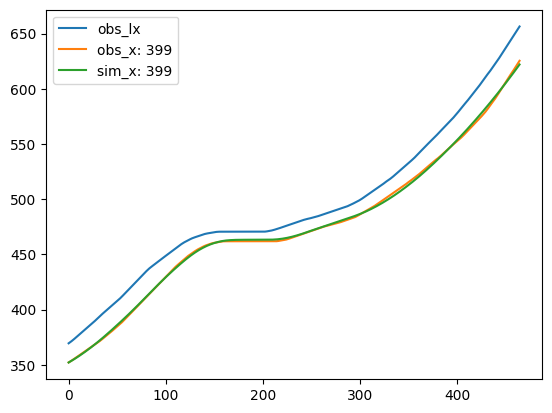

In [13]:
from trasim_simplified.util.calibrate.clb_cf_model import show_traj
import random

pos = random.choice(range(len(id_s)))
# pos = param_df[param_df[TI.Pair_ID] == 2778].index[0]

target = param_df[param_df[TI.Pair_ID] == id_s[pos]]
obs_x = obs_x_s[pos]
obs_v = obs_v_s[pos]
obs_lx = obs_lx_s[pos]
obs_lv = obs_lv_s[pos]
leaderL = leaderL_s[pos]
show_traj(cf_name, target.to_numpy().reshape(-1), dt, obs_x, obs_v, obs_lx, obs_lv, leaderL, traj_step=None, pair_ID=id_s[pos])

In [14]:
from trasim_simplified.util.tools import save_to_pickle
from trasim_simplified.util.calibrate.clb_cf_model import get_clb_traj

clb_traj_s = get_clb_traj(traj_s_full, traj_s_cut_pos, param_df, cf_func, cf_name, dt)

save_to_pickle(clb_traj_s,
               r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_traj_s.pkl")